<a href="https://colab.research.google.com/github/munich-ml/MLPy2020/blob/master/31_fMNIST_classifier_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

## References
Resources used to create this notebook:
- [scikit-learn website](https://scikit-learn.org)
- [Matplotlib website](https://matplotlib.org/)
- [Wikipedia](https://en.wikipedia.org/wiki/Main_Page)
- Hands-on Machine Learning with Scikit-learn, Keras & TensorFlow, Aurelien Geron, [Book on Amazon](https://www.amazon.de/Aur%C3%A9lien-G%C3%A9ron/dp/1492032646/ref=sr_1_3?__mk_de_DE=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=Hands-on+Machine+Learning+with+Scikit-learn%2C+Keras+%26+TensorFlow%2C+Aurelien+Geron%2C&qid=1589875241&sr=8-3)
- Introduction to Machine Learning with Python, Andreas Mueller, [Book on Amazon](https://www.amazon.de/Introduction-Machine-Learning-Python-Scientists/dp/1449369413)


## Setup

First, do the common imports.

Tensorflow must be 2.x, because there are major changes from 1.x

In [54]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Forces tensorflow version (only in colab)
%tensorflow_version 2.x           

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import os
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Setup matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get munich-ml helper functions from GitHub
if "MLPy2020" in os.listdir():
    !git -C MLPy2020 pull
else:
    !git clone https://github.com/munich-ml/MLPy2020/

from MLPy2020.MLPy_helper_funcs import pickle_out

Already up to date.


In [55]:
tf.__version__

'2.2.0'

# Get the data

MNIST is probably THE classical dataset for image recognition. Meanwhile the more challanging fashion MNIST \[[on Github](https://github.com/zalandoresearch/fashion-mnist)] from Zalando took over.

Keras has a number of functions to load popular datasets in `keras.datasets`. 

The fashion MNIST dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:


In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

From the dataset documentation we know, that the **labels** are **class IDs** that correspond to the following **`class_names`**:

In [0]:
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [59]:
class_names[y_train_full[0]]

'Ankle boot'

Plot part of the dataset to get an overview


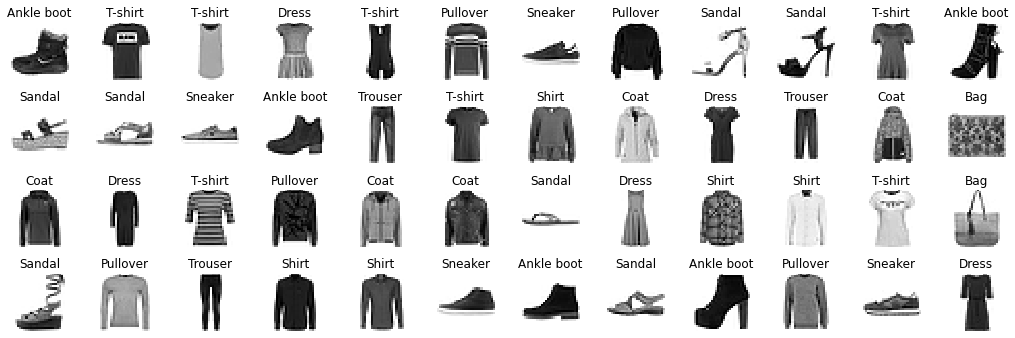

In [61]:
# code for viewing, not for teaching
n_rows = 4
n_cols = 12
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_full[index], cmap="binary", interpolation="nearest")
        plt.title(class_names[y_train_full[index]], fontsize=12)
        plt.axis('off')
        
plt.tight_layout()
plt.show()

##Inpect the data


The training set contains 60,000 grayscale images, each 28x28 pixels:

In [62]:
X_train_full.shape

(60000, 28, 28)

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

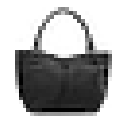

In [68]:
plt.figure(figsize=(2,2))
plt.imshow(X_train_full[100, :, :], cmap=plt.cm.binary)
plt.axis("off");

Each pixel intensity is an 8bit interger value.
- 0 is white
- 255 is black

In [9]:
type(X_train_full[0,0,0])

numpy.uint8

In [69]:
X_train_full[100,:,:13]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,  18],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  99, 155],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   0, 110, 136,   0],
       [  0,   0,   0,   0,   0,   1,   0,   6,   0,  72, 147,   0,   0],
       [  0,   0,   0,   0,   0,   1,   5,   0,   0, 174,   4,   0,   4],
       [  0,   0,   0,   0,   0,   0,   8,   0, 125, 128,   0,   9,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 184,   9,   0,   4,   0],
       [  0,   0,   0,   1,   0,   2,   0,  73, 158,   0,   0,   0,   0],
       [  0,   0,   2,   5,   1,   0,   0, 157,  98,   0,   2,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 231,  84,   0,   2,   1,   1],
       [  0,   0,   0,   0,   0,   0,  38, 183,  81,   0,   0,   0,   2],
       [  0,   0, 173, 216, 193, 213, 183, 164, 167,  98,  16,   0,   0],
       [  0,   0, 185, 221, 217, 210, 202, 222, 200, 206, 202, 204, 109],
       [  0,   0, 183, 220, 205, 200, 

## Scale the data

Since we are going to train the neural network using **Gradient Descent**, we must scale the input features. 

For simplicity, we just divide by 255.0 (which converts the features from `int` to `float`)

In [70]:
scale = X_train_full.max()
scale

255

In [0]:
X_train_full = X_train_full / scale
X_test = X_test / scale

In [72]:
X_test.max()

1.0

##Split a validation set

Let's split the *full training set* into a *validation set* and a (smaller) *training set*. But first check whether the images are sorted.

The labels are the class IDs (represented as uint8), from 0 to 9:

In [73]:
y_train_full

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Assessing the *class ID's* randomness: 

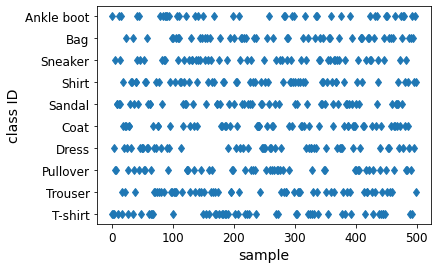

In [77]:
plt.plot(y_train_full[:500], "d")
plt.xlabel("sample"), plt.ylabel("class ID")
plt.yticks(range(len(class_names)), labels=class_names);

The distribution seems random. Therefore the training set can be splitted.

In [0]:
valid_size = 5000
X_valid = X_train_full[:valid_size]
X_train = X_train_full[valid_size:]


y_valid, y_train = y_train_full[:valid_size], y_train_full[valid_size:]

Plot the shapes of the resulting sets

In [76]:
for item in ("X_train_full", "X_train", "X_valid", "X_test"):
    if item in locals():
        print("{}.shape: {}".format(item, eval(item + ".shape")))

X_train_full.shape: (60000, 28, 28)
X_train.shape: (55000, 28, 28)
X_valid.shape: (5000, 28, 28)
X_test.shape: (10000, 28, 28)


# Build a model

This colde creates a classification MLP (multi layer perceptron) with 2 hidden layers:

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

Alternatively to using `model.add` we can pass a list of layers to the `Sequential()` constructor

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(47)

In [0]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation=keras.activations.relu),
    keras.layers.Dense(100, activation=keras.activations.relu),
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

In [82]:
keras.activations.relu([-2, -1, 0, 1, 2])

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 0, 1, 2], dtype=int32)>

## Model summary

Let's print a summary of the model, using `model.summary()`


In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Note the huge amount of (trainable) parameters. For example, the first hidden layer has 784 * 300 connection weights, plus 300 bias terms. This gives the model quite a flexibility to fit the training data, but it's also prone to overfitting, especially with few traning data.

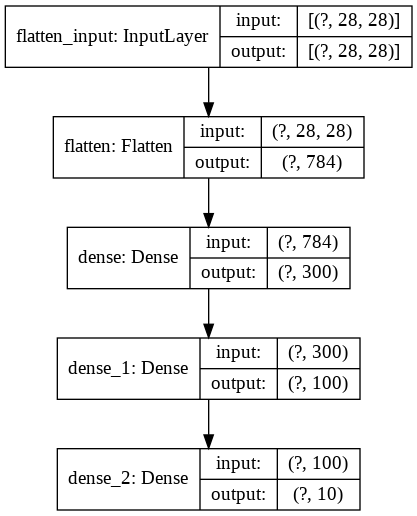

In [84]:
keras.utils.plot_model(model, show_shapes=True)

The layers of the model can be accessed with `model.layers`

In [85]:
for i, layer in enumerate(model.layers):
    print("layer {}: {}".format(i, layer.name))

layer 0: flatten
layer 1: dense
layer 2: dense_1
layer 3: dense_2


In [0]:
weights, biases = model.layers[2].get_weights()

In [88]:
weights.shape

(300, 100)

In [89]:
weights

array([[ 0.04602376, -0.0038019 ,  0.10557164, ...,  0.05382182,
        -0.09810888,  0.10975555],
       [-0.0131605 , -0.0401491 , -0.01301397, ..., -0.06764732,
        -0.05142808, -0.10832162],
       [ 0.0748878 ,  0.11689269,  0.06693598, ...,  0.04704887,
        -0.04119989,  0.1031863 ],
       ...,
       [-0.08606555,  0.1186113 , -0.11932244, ...,  0.1080649 ,
        -0.10135629,  0.05048553],
       [-0.1144025 , -0.06622341,  0.00440084, ..., -0.00439373,
         0.01447021,  0.02337808],
       [-0.10965011,  0.05632766,  0.11904002, ..., -0.0713827 ,
         0.11915682, -0.10558839]], dtype=float32)

In [90]:
biases.shape

(100,)

In [91]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Note that the biases are initialized with zeros while the weights are initalized randomly. This is required to support convergence.

# Train the model

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [0]:
model.compile?

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

Some explanation to the `compile` params:
- The loss must be **sparse_**categorical_crossentropy because the labels are sparse, meaning just one value per training instance and not a tensor of len(10)
- The optimizer is a simple **Stochastic Gradient Descent**
- Since this is a **classifier**, it's useful to measure **accuracy** during training 

Now, let's kick-off training using `model.fit`

In [93]:
history = model.fit(X_train, y_train, epochs=30, verbose=1,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7237 - accuracy: 0.7644 - val_loss: 0.5207 - val_accuracy: 0.8234
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4843 - accuracy: 0.8318 - val_loss: 0.4345 - val_accuracy: 0.8538
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4393 - accuracy: 0.8455 - val_loss: 0.5288 - val_accuracy: 0.8002
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4126 - accuracy: 0.8565 - val_loss: 0.3919 - val_accuracy: 0.8652
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3939 - accuracy: 0.8620 - val_loss: 0.3751 - val_accuracy: 0.8678
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3752 - accuracy: 0.8676 - val_loss: 0.3709 - val_accuracy: 0.8714
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3633 - accuracy: 0.8715 - val_loss: 0.3613 - val_accuracy:

In [94]:
history.params

{'epochs': 30, 'steps': 1719, 'verbose': 1}

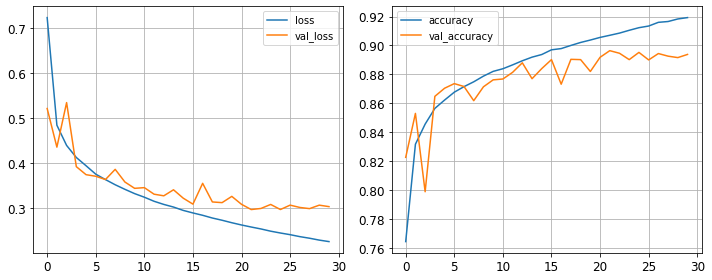

In [53]:
fig = plt.figure(figsize=[10, 4]) 
axes = fig.subplots(nrows=1, ncols=2)
for i, word in enumerate(["loss", "accuracy"]):
    for key, vals in history.history.items():
        if word in key:
            axes[i].plot(vals, label=key)
for ax in axes:
    ax.grid(), ax.legend()
fig.tight_layout()

## Mount google drive

In [34]:
mount_dir = os.path.join(os.getcwd(), "drive")
mount_dir

'/content/drive'

In [35]:
from google.colab import drive
drive.mount(mount_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## model.save()


In [36]:
save_dir = os.path.join(mount_dir, "My Drive", "Colab Notebooks", "models")
save_dir

'/content/drive/My Drive/Colab Notebooks/models'

In [0]:
fn = "fMNIST_NN_v2_ageron"
model.save(os.path.join(save_dir, fn + ".h5"))

### Save validation and test data along with the model

In [0]:
pickle_out(os.path.join(save_dir, fn+"_data.pkl"), locals(),
           X_valid, y_valid, X_test, y_test, class_names)